In [17]:
%pip install --upgrade --quiet pip setuptools wheel matplotlib seaborn
%pip install --upgrade --quiet  langchain langchain-openai faiss-cpu tiktoken crate 'crate[sqlalchemy]' pandas jq 
%pip install --use-pep517 --quiet python-dotenv

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Evaluate RAG search with CrateDB vector, fulltext, fusion and OpenAI

## Setup environment variables

In [18]:
import os

from dotenv import load_dotenv

load_dotenv()

True

## setup embeddings

In [19]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings()
len(embeddings.embed_query("a"))

1536

In [20]:
conn_url = "crate://{user}:{password}@{server}".format(
    user=os.environ["CRATEDB_USER"],
    password=os.environ["CRATEDB_PASS"],
    server=os.environ["CRATEDB_SERVER"],
)
conn_url

'crate://crate:@localhost:4200'

In [21]:
# open file
from langchain_community.document_loaders import JSONLoader, DirectoryLoader


def metadata_func(record: dict, metadata: dict) -> dict:
    metadata["source_url"] = record.get("url")
    metadata["source_title"] = record.get("title")

    if "source" in metadata:
        metadata["source"] = metadata["source_url"]

    return metadata


loader = DirectoryLoader(
    './',
    glob="everything-*.json",
    loader_cls=JSONLoader,
    loader_kwargs={
        "jq_schema": ".[]",
        "text_content": False,
        "content_key": "html",
        "metadata_func": metadata_func,
    }
)

data = loader.load()
# data[:1]

In [22]:
# split documents
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    separators=[
        "\n\n",
        "\n",
        " ",
        ".",
        ",",
    ],
    chunk_size=500,
    chunk_overlap=50,
    length_function=len,
    is_separator_regex=False,
)

docs_splits = text_splitter.split_documents(data)
# docs_splits[:2]

## RAG search, indexing pipeline

In [23]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import ChatOpenAI

In [24]:
from rag.vectorstore.crate import CrateVectorStore

vectorstore = CrateVectorStore.from_documents(
    # assumes that data was imported already
    # allow faster recomputation of notebook, without need of reindexing
    # documents=[],
    documents=docs_splits,
    embedding=embeddings,
    database_kwargs={
        "database_uri": conn_url,
    },
    # vectorstore_kwargs={
    #    "drop_if_exists" : True,
    # },
)
vectorstore

In [25]:
from langchain.retrievers import EnsembleRetriever

retriever_a = vectorstore.as_retriever(
    search_kwargs={'k': 10, 'fetch_k': 100, "algorith": "knn"}
)

retriever_b = vectorstore.as_retriever(
    search_kwargs={'k': 10, 'fetch_k': 100, "algorith": "fulltext"}
)

retriever_c = EnsembleRetriever(
    retrievers=[
        retriever_a,
        retriever_b
    ],
    weights=[0.5, 0.5],
)

In [26]:
import json

In [27]:
template = """Answer the question based only on the context, if possible use links to reference the source, use markdown, avoid answering when the context and question are not related.

today date is 2024 April 3rd

{context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)
model = ChatOpenAI()


def format_docs(docs):
    breakpoint()
    return json.dumps([{"text": d.page_content, "source": d.metadata.get('source')} for d in docs])


chain_a = (
        {"context": retriever_a | format_docs,
         "question": RunnablePassthrough()}
        | prompt
        | model
        | StrOutputParser()
)

chain_b = (
        {"context": retriever_b | format_docs,
         "question": RunnablePassthrough()}
        | prompt
        | model
        | StrOutputParser()
)

chain_c = (
        {"context": retriever_c | format_docs,
         "question": RunnablePassthrough()}
        | prompt
        | model
        | StrOutputParser()
)

# result = chain.invoke("How to limit permissions?")
# result = chain.invoke(" How AWS marketplace works, and why I cannot see deployment in my account?")
# result = chain.invoke("What are edge regions and how to use them?")
result = chain_a.invoke("Write me example of using blobs?")
# result = chain.invoke("How to use BLOB store in CrateDB? and what are the benefits?")
result


'To use blobs in CrateDB, you first need to create a blob table using the Crate Shell. Here is an example SQL statement:\n\n```sh\ncrash -c "create blob table myblobs clustered into 3 shards with (number_of_replicas=1)"\n```\n\nOnce the blob table is created, you can upload a blob by issuing a PUT request. For example:\n\n```sh\ncurl -isSX PUT \'127.0.0.1:4200/_blobs/myblobs/4a756ca07e9487f482465a99e8286abc86ba4dc7\' -d \'contents\'\n```\n\nYou can also delete a blob using a DELETE request:\n\n```sh\ncurl -isS -XDELETE \'127.0.0.1:4200/_blobs/myblobs/4a756ca07e9487f482465a99e8286abc86ba4dc7\'\n```\n\nFor more information on using blobs in CrateDB, you can refer to the [official documentation](https://cratedb.com/docs/crate/reference/en/3.3/general/blobs.html).'

In [28]:
from IPython.display import display, Markdown

display(Markdown(result))

To use blobs in CrateDB, you first need to create a blob table using the Crate Shell. Here is an example SQL statement:

```sh
crash -c "create blob table myblobs clustered into 3 shards with (number_of_replicas=1)"
```

Once the blob table is created, you can upload a blob by issuing a PUT request. For example:

```sh
curl -isSX PUT '127.0.0.1:4200/_blobs/myblobs/4a756ca07e9487f482465a99e8286abc86ba4dc7' -d 'contents'
```

You can also delete a blob using a DELETE request:

```sh
curl -isS -XDELETE '127.0.0.1:4200/_blobs/myblobs/4a756ca07e9487f482465a99e8286abc86ba4dc7'
```

For more information on using blobs in CrateDB, you can refer to the [official documentation](https://cratedb.com/docs/crate/reference/en/3.3/general/blobs.html).

## Evaluation

In [29]:
questions = [
    "Write me example of using blobs?",
    "How to use BLOB store in CrateDB? and what are the benefits?",
    "How to limit permissions?",
    "How AWS marketplace works, and why I cannot see deployment in my account?",
    "What are edge regions and how to use them?",
    "What are recent blog posts about CrateDB?",
    "Write me example python code to use CrateDB?",
    "Write me example golang code to use CrateDB?",
    "create RAG search with CrateDB and OpenAI?",
    "how to alter table and add fulltext index?",
    "how to alter table and add vector type field that allows for KNN search?",
    "create table with fields ID, name, vector, and index vector field for KNN search?",
    "What are limits and limitations of CrateDB?",
    "What are the benefits of using CrateDB?",
    "Does index creation block write operations?",
    "Does crate supports conditional indices",
    "How to create ID field that is autoincremented?",
    "how to create analysers for fulltext search?",
    "give me information about password and admin",
    "Shared file system implementation of the BlobStoreRepository",
    "Is Cloud UI opensource?",
    "How to do fusion search and connect vector search with fulltext search",
    "How to MATH fulltext "
    "Benchmarks of CrateDB",
]

In [30]:
from langchain.evaluation import load_evaluator
from langchain.evaluation.criteria import Criteria

criteria = [
    Criteria.COHERENCE,
    Criteria.RELEVANCE,
    Criteria.DETAIL,
    Criteria.HARMFULNESS,
    Criteria.HELPFULNESS,
]

criteria2 = {
    "runnable": "Software engineer who is looking for information can copy and paste the code and it should work",
    "relevance": "The answer is relevant to the question",
    "grounded": "The answer links to the source of the information",
    "coherence": "The answer is coherent and makes sense",
    "detail": "The answer is detailed and provides enough information",
    "helpfulness": "The answer is helpful and provides value",
}

evaluator = load_evaluator("pairwise_string", criteria=criteria)

In [31]:
question = "Write me example of using blobs?"
prediction = chain_a.invoke(question)
prediction_b = chain_b.invoke(question)

ev = evaluator.evaluate_string_pairs(
    prediction=prediction,
    prediction_b=prediction_b,
    input=question
)

In [32]:
ev

{'reasoning': "Both assistants provide coherent, relevant, and detailed responses. Neither response is harmful, offensive, or inappropriate. However, Assistant B's response is more helpful and insightful as it not only explains how to create a BLOB table but also how to upload, list, query, and delete BLOBs. Assistant A's response, while accurate, only explains how to create a BLOB table and does not provide any further information on how to use BLOBs. Therefore, Assistant B's response is more comprehensive and useful. \n\nFinal verdict: [[B]]",
 'value': 'B',
 'score': 0}

In [33]:
from random import random

def eval(questions, chain_a, chain_b, aname="A", bname="B", cname=None):
    evaluation_results = []

    for question in questions:
        prediction = chain_a.invoke(question)
        prediction_b = chain_b.invoke(question)
        # prediction_c = chain_c.invoke(question)
        
        # swap prediction to avoid bias in evaluator

        choice = random() > 0.5
        if choice:
            prediction, prediction_b = prediction_b, prediction

        ev = evaluator.evaluate_string_pairs(
            prediction=prediction,
            prediction_b=prediction_b,
            input=question
        )
        
        if choice:
            ev = {
                "value": {aname: bname, bname: aname, cname: cname}[ev["value"]],
                "score": ev["score"],
                "reasoning": "Swapped prediction: {}".format(ev["reasoning"])
            }
        
        evaluation_results.append({
            "choice": choice,
            "question": question,
            f"prediction_{aname}": prediction if choice else prediction_b,
            f"prediction_{bname}": prediction_b if choice else prediction,
            **ev
        })
        
    return evaluation_results


In [35]:
import pandas as pd
evaluation_results_ab_df = pd.DataFrame(eval(questions, chain_a, chain_b))
evaluation_results_ab_df

,choice,question,prediction_A,prediction_B,value,score,reasoning
0,True,Write me example of using blobs?,"To use blobs in CrateDB, you first need to cre...","To use blobs in Crate, you first need to creat...",B,1.0,Swapped prediction: Both Assistant A and Assis...
1,False,How to use BLOB store in CrateDB? and what are...,"To use BLOB storage in CrateDB, you can store ...","To use BLOB storage in CrateDB, you can store ...",A,1.0,Both Assistant A and Assistant B provided cohe...
2,True,How to limit permissions?,"To limit permissions in CrateDB, it is recomme...","To limit permissions in CrateDB, it is recomme...",A,0.0,Swapped prediction: Both assistants provide re...
3,True,"How AWS marketplace works, and why I cannot se...",To deploy a cluster on CrateDB Cloud via AWS M...,To deploy a cluster on CrateDB Cloud via AWS M...,A,0.0,Swapped prediction: Both assistants provide co...
4,True,What are edge regions and how to use them?,Edge regions are components of a deployed Edge...,Edge regions are components that need to be up...,A,0.0,Swapped prediction: Both assistants provide co...
5,False,What are recent blog posts about CrateDB?,Recent blog posts about CrateDB include:\n\n1....,The recent blog posts about CrateDB include:\n...,A,1.0,Both Assistant A and Assistant B provided cohe...
6,False,Write me example python code to use CrateDB?,"To write example python code to use CrateDB, y...","To use CrateDB with Python, you can refer to t...",B,0.0,Both Assistant A and Assistant B provided rele...
7,True,Write me example golang code to use CrateDB?,"To connect to CrateDB using Go, you can utiliz...","To use CrateDB with Go, you can utilize the `p...",None,0.5,Swapped prediction: Both Assistant A and Assis...
8,True,create RAG search with CrateDB and OpenAI?,To create a RAG search with CrateDB and OpenAI...,To create a RAG (Retrieval Augmented Generatio...,B,1.0,Swapped prediction: Both Assistant A and Assis...
9,True,how to alter table and add fulltext index?,"To alter a table and add a fulltext index, you...","To alter a table and add a fulltext index, you...",A,0.0,Swapped prediction: Both assistants provide co...


In [36]:
evaluation_results_ac_df = pd.DataFrame(eval(questions, chain_a, chain_c))
evaluation_results_ac_df

,choice,question,prediction_A,prediction_B,reasoning,value,score
0,False,Write me example of using blobs?,"To use blobs in Crate, you can create a blob t...","To use blobs in CrateDB, first, a blob table m...",Both Assistant A and Assistant B provided cohe...,B,0.0
1,False,How to use BLOB store in CrateDB? and what are...,"To use BLOB store in CrateDB, you can store bi...","To use BLOB storage in CrateDB, you can store ...",Both Assistant A and Assistant B provided cohe...,A,1.0
2,True,How to limit permissions?,"To limit permissions in CrateDB, users need to...","To limit permissions in CrateDB, it is recomme...",Swapped prediction: Both Assistant A and Assis...,B,1.0
3,True,"How AWS marketplace works, and why I cannot se...",To subscribe to CrateDB Cloud's offering on AW...,To deploy a cluster on CrateDB Cloud through A...,Swapped prediction: Both Assistant A and Assis...,B,1.0
4,False,What are edge regions and how to use them?,Edge regions are custom regions created within...,Edge regions are components of a deployed Edge...,Both Assistant A and Assistant B provide coher...,B,0.0
5,False,What are recent blog posts about CrateDB?,Recent blog posts about CrateDB include:\n1. [...,Recent blog posts about CrateDB include:\n1. [...,Both Assistant A and Assistant B provided cohe...,B,0.0
6,False,Write me example python code to use CrateDB?,"To use CrateDB with Python, you can refer to t...","To write example python code to use CrateDB, y...",Both assistants provided relevant and helpful ...,B,0.0
7,True,Write me example golang code to use CrateDB?,"To use CrateDB with Golang, you can refer to t...","To use CrateDB with Go, you can utilize the pg...",Swapped prediction: Both Assistant A and Assis...,None,0.5
8,True,create RAG search with CrateDB and OpenAI?,To create a RAG search with CrateDB and OpenAI...,To create a RAG (Retrieval Augmented Generatio...,Swapped prediction: Both assistants provide re...,B,1.0
9,True,how to alter table and add fulltext index?,"To alter a table and add a fulltext index, you...",To alter a table and add a fulltext index in C...,Swapped prediction: Both assistants provide re...,B,1.0


In [37]:
evaluation_results_bc_df = pd.DataFrame(eval(questions, chain_b, chain_c))
evaluation_results_bc_df

,choice,question,prediction_A,prediction_B,reasoning,value,score
0,False,Write me example of using blobs?,"To use blobs in CrateDB, you first need to cre...","To upload a blob using Crate, you can issue a ...","Both assistants provide coherent, relevant, an...",B,0.0
1,True,How to use BLOB store in CrateDB? and what are...,"To use BLOB storage in CrateDB, you can store ...","To use BLOB storage in CrateDB, you can store ...",Swapped prediction: Both assistants provided c...,B,1.0
2,False,How to limit permissions?,"To limit permissions in CrateDB, users can uti...","To limit permissions in CrateDB, it is recomme...",Both assistants provide relevant and coherent ...,B,0.0
3,False,"How AWS marketplace works, and why I cannot se...",To subscribe to CrateDB Cloud's offering on AW...,To subscribe to CrateDB Cloud's offering on AW...,Both Assistant A and Assistant B provide coher...,B,0.0
4,True,What are edge regions and how to use them?,Edge regions are custom regions that can be cr...,Edge regions are components of a deployed Edge...,Swapped prediction: Both assistants provide co...,B,1.0
5,False,What are recent blog posts about CrateDB?,Recent blog posts about CrateDB include:\n1. [...,Recent blog posts about CrateDB include:\n1. [...,Both Assistant A and Assistant B provided cohe...,B,0.0
6,True,Write me example python code to use CrateDB?,You can find example Python code to use CrateD...,"To write example Python code to use CrateDB, y...",Swapped prediction: Both assistants provided r...,A,0.0
7,False,Write me example golang code to use CrateDB?,"To use CrateDB with Go, you can follow the exa...","To connect to CrateDB using Go, you can use th...","Both assistants provided coherent, relevant, a...",B,0.0
8,False,create RAG search with CrateDB and OpenAI?,To create a RAG search with CrateDB and OpenAI...,To create a RAG (Retrieval Augmented Generatio...,Both Assistant A and Assistant B provided cohe...,B,0.0
9,False,how to alter table and add fulltext index?,"Based on the context provided, to add a fullte...",To alter a table and add a fulltext index in C...,Both Assistant A and Assistant B provided cohe...,A,1.0


# Analysis of evaluation results
- Which variant was preferred more?
- What is probability that people presented with a variant A over B will be more happy?
- Which prediction variant on average performed better?
- What is distribution of scores for each prediction variant?

## Which variant was preferred more? as percentage

In [53]:
total = len(questions)
# value can be A, B, None, None means that both predictions are equal, show None as C
# dived by total to get percentage contribution from all evaluations 
# multiply by 100 to get percentage
ab_res = evaluation_results_ab_df['value'].fillna("X").value_counts() / total * 100
ab_res

value
B    43.478261
A    39.130435
X    17.391304
Name: count, dtype: float64

In [54]:
ac_res = evaluation_results_ac_df['value'].fillna("X").replace('B', 'C').value_counts() / total * 100
ac_res

value
C    60.869565
A    26.086957
X    13.043478
Name: count, dtype: float64

In [55]:
bc_res = evaluation_results_bc_df['value'].fillna("X").replace("B", "C").replace("A", "B").value_counts() / total * 100
bc_res

value
C    52.173913
B    39.130435
X     8.695652
Name: count, dtype: float64

# Conclusion
From the results we can see that the variant C(knn+fulltext) was preferred more often, 
and the variant A(knn) was preferred the least.

In [68]:
joined = pd.concat([evaluation_results_bc_df['value'].replace("B", "C").replace("A", "B"), 
                    evaluation_results_ac_df['value'].replace('B', 'C'), 
                    evaluation_results_ab_df['value']], axis=0)
joined.fillna("X", inplace=True)
joined

0     C
1     C
2     C
3     C
4     C
     ..
18    A
19    B
20    A
21    X
22    A
Name: value, Length: 69, dtype: object

In [69]:
# statistics
joined.describe()

count     69
unique     4
top        C
freq      26
Name: value, dtype: object

<Axes: xlabel='value'>

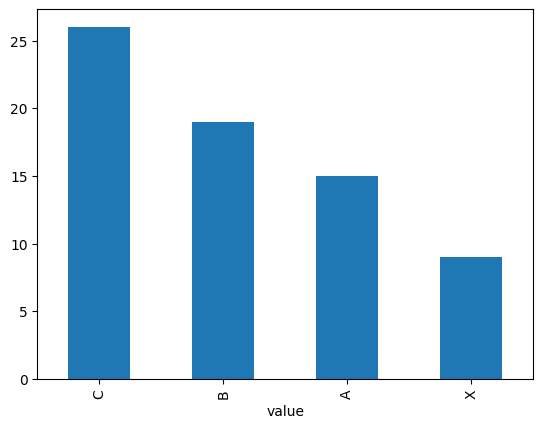

In [73]:
joined.value_counts().plot.bar()